In [ ]:
%load_ext autoreload
%autoreload 2
import sys

# instead of creating a package using setup.py or building from a docker/singularity file,
# import the sister directory of src code to be called on in notebook.
# This keeps the notebook free from code to only hold visualizations and is easier to test
# It also helps keep the state of variables clean such that cells aren't run out of order with a mysterious state
sys.path.append("..")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import emd
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from statistics import mean
import statistics
from dateutil.parser import parse

In [ ]:
def load_nysm_data():
    # these parquet files are created by running "get_resampled_nysm_data.ipynb"
    nysm_path = "/home/aevans/nwp_bias/data/nysm/"

    nysm_1H = []
    for year in np.arange(2018, 2023):
        df = pd.read_parquet(f"{nysm_path}nysm_1H_obs_{year}.parquet")
        df.reset_index(inplace=True)
        nysm_1H.append(df)
    nysm_1H_obs = pd.concat(nysm_1H)
    nysm_1H_obs["snow_depth"] = nysm_1H_obs["snow_depth"].fillna(0)
    nysm_1H_obs.dropna(inplace=True)
    return nysm_1H_obs

In [ ]:
def read_hrrr_data():
    """
    Reads and concatenates parquet files containing forecast and error data for HRRR weather models
    for the years 2018 to 2022.

    Returns:
        pandas.DataFrame: of hrrr weather forecast information for each NYSM site.
    """

    years = ["2018", "2019", "2020", "2021", "2022"]
    savedir = "/home/aevans/ai2es/processed_data/HRRR/ny/"

    # create empty lists to hold dataframes for each model
    hrrr_fcast_and_error = []

    # loop over years and read in parquet files for each model
    for year in years:
        for month in np.arange(1, 13):
            str_month = str(month).zfill(2)
            if (
                os.path.exists(
                    f"{savedir}HRRR_{year}_{str_month}_direct_compare_to_nysm_sites_mask_water.parquet"
                )
                == True
            ):
                hrrr_fcast_and_error.append(
                    pd.read_parquet(
                        f"{savedir}HRRR_{year}_{str_month}_direct_compare_to_nysm_sites_mask_water.parquet"
                    )
                )
            else:
                continue

    # concatenate dataframes for each model
    hrrr_fcast_and_error_df = pd.concat(hrrr_fcast_and_error)
    hrrr_fcast_and_error_df = hrrr_fcast_and_error_df.reset_index().dropna()

    # return dataframes for each model
    return hrrr_fcast_and_error_df

In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd


def format_climate_df(data_path):
    """
    Formats a climate data file located at the specified `data_path` into a pandas DataFrame.

    Args:
        data_path (str): The file path for the climate data file.

    Returns:
        pandas.DataFrame: A DataFrame containing the climate data, with the first column renamed to "year".
    """
    raw_index = np.loadtxt(f"{data_path}")
    cl_index = pd.DataFrame(raw_index)
    cl_index = cl_index.rename(columns={0: "year"})
    return cl_index

In [ ]:
# def nwp_error(target, nysm_df, hrrr_df):
#     df = pd.DataFrame()

#     vars_dict = {
#         "t2m": "tair",
#         "mslma": "pres",
#     }
#     nysm_var = vars_dict.get(target)

#     target_error = []
#     for i,_ in enumerate(nysm_df['time_1H']):
#         if nysm_df['time_1H'].iloc[i] == hrrr_df['time']


#     df["target_error"] = hrrr_df[f"{target}"] - nysm_df[f"{nysm_var}"]
#     return df

In [ ]:
def groupby_month(df, col):
    df = df[df[col] > -999]
    GB = df.groupby([(df.time_1H.dt.month)])[col].mean()
    the_list = GB.tolist()
    fig, ax = plt.subplots(figsize=(21, 6))
    plt.plot(the_list)
    # ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])
    # ax.set_xticks(np.arange(0, 60, 12))
    return the_list

In [ ]:
def groupby_month_hrrr(df, col):
    df = df[df[col] > -999]
    GB = df.groupby([(df.time.dt.month), (df.time.dt.year)])[col].mean()
    the_list = GB.tolist()
    fig, ax = plt.subplots(figsize=(21, 6))
    plt.plot(the_list)
    ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])
    ax.set_xticks(np.arange(0, 60, 12))
    return the_list

In [ ]:
def anoms_detection_hrrr(df, means, col):
    anoms = []

    for i, _ in enumerate(df["time"]):
        t = df["time"].iloc[i]
        tair = df[col].iloc[i]
        dt_object = parse(str(t))
        year = dt_object.strftime("%Y")
        month = dt_object.strftime("%m")

        for m in np.arange(1, 13):
            # new_means = means[:12]
            # anom = tair - new_means[m-1]
            # if abs(anom) > 60.0:
            #     anoms.append(anom)
            # else:
            #     anoms.append(00)
            if year == str(2018) and month == str(m).zfill(2):
                new_means = means[:12]
                anom = tair - new_means[m - 1]
                anoms.append(anom)
            if year == str(2019) and month == str(m).zfill(2):
                new_means = means[12:24]
                anom = tair - new_means[m - 1]
                anoms.append(anom)
            if year == str(2020) and month == str(m).zfill(2):
                new_means = means[24:36]
                anom = tair - new_means[m - 1]
                anoms.append(anom)
            if year == str(2021) and month == str(m).zfill(2):
                new_means = means[36:48]
                anom = tair - new_means[m - 1]
                anoms.append(anom)
            if year == str(2022) and month == str(m).zfill(2):
                new_means = means[48:60]
                anom = tair - new_means[m - 1]
                anoms.append(anom)

    fig, ax = plt.subplots(figsize=(21, 7))
    plt.plot(anoms, c="red")
    print(len(anoms))
    ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])
    ax.set_xticks(np.arange(0, len(anoms), (len(anoms) / 5)))

In [ ]:
def anoms_detection(df, means, col):
    anoms = []

    for i, _ in enumerate(df["time_1H"]):
        t = df["time_1H"].iloc[i]
        tair = df[col].iloc[i]
        dt_object = parse(str(t))
        year = dt_object.strftime("%Y")
        month = dt_object.strftime("%m")

        for m in np.arange(1, 13):
            new_means = means[:12]
            anom = tair - new_means[m - 1]
            anoms.append(anom)

        # if year == str(2018) and month == str(m).zfill(2):
        #     new_means = means[:12]
        #     anom = tair - new_means[m-1]
        #     anoms.append(anom)
        # if year == str(2019) and month == str(m).zfill(2):
        #     new_means = means[12:24]
        #     anom = tair - new_means[m-1]
        #     anoms.append(anom)
        # if year == str(2020) and month == str(m).zfill(2):
        #     new_means = means[24:36]
        #     anom = tair - new_means[m-1]
        #     anoms.append(anom)
        # if year == str(2021) and month == str(m).zfill(2):
        #     new_means = means[36:48]
        #     anom = tair - new_means[m-1]
        #     anoms.append(anom)
        # if year == str(2022) and month == str(m).zfill(2):
        #     new_means = means[48:60]
        #     anom = tair - new_means[m-1]
        #     anoms.append(anom)

    fig, ax = plt.subplots(figsize=(21, 6))
    plt.plot(anoms, c="red")
    print(len(anoms))
    ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])
    ax.set_xticks(np.arange(0, len(anoms), (len(anoms) / 5)))

In [ ]:
# # import data
# df = pd.read_parquet(
#     "/home/aevans/nwp_bias/src/machine_learning/data/clean_parquets/met_geo_cats/cleaned_rough_lstm_geo_met_cat_orange.parquet"
# )
# df.head()

In [ ]:
directory = sorted(os.listdir("/home/aevans/nwp_bias/src/correlation/data/indexes"))

# years = ['2018', '2019', '2020', '2021', '2022']
years = np.arange(2018, 2023)
for d in directory:
    if d != "csv":
        path = f"/home/aevans/nwp_bias/src/correlation/data/indexes/{d}"
        cldf = format_climate_df(path)
        cldf = cldf[cldf["year"].isin(years)]
        filename = d

        # plot
        parts = filename.split(".")
        title = parts[0]
        cldf = cldf.drop(columns=["year"])
        y = []
        for d, _ in enumerate(cldf[1]):
            vals = cldf.iloc[d]
            for v in vals:
                y.append(v)

        x = np.arange(0, len(y))
        print(len(y))

        fig, ax = plt.subplots(figsize=(21, 7))
        plt.plot(
            x,
            y,
        )
        plt.title(f"{title}")
        ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])
        ax.set_xticks(np.arange(0, len(y), (len(y) / 5)))
        ax.axhline(y=0, c="black")
        ax.set_ylim(-3, 3)
        plt.show()

In [15]:
hrrr_df = read_hrrr_data()
hrrr_df = hrrr_df[hrrr_df["station"] == "OLEA"]
hrrr_df

,valid_time,time,station,level_0,index,latitude,longitude,t2m,sh2,d2m,...,asnow,cape,dswrf,dlwrf,gh,u_total,u_dir,lead time,lsm,new_tp
35697,2018-01-01 02:00:00,2018-01-01 00:00:00,OLEA,60337221,123415,42.097365,-78.391637,-18.836386,0.00069,-21.812979,...,0.000020,0.0,0.0,151.300003,5223.541992,2.961729,338.473083,2,1.0,0.001
35698,2018-01-01 03:00:00,2018-01-01 01:00:00,OLEA,60337222,329071,42.097365,-78.391637,-20.699194,0.00059,-23.618216,...,0.000060,0.0,0.0,150.300003,5217.613281,2.798458,337.496521,2,1.0,0.003
35699,2018-01-01 04:00:00,2018-01-01 02:00:00,OLEA,60337223,534727,42.097365,-78.391637,-20.743689,0.00057,-24.043570,...,0.000017,0.0,0.0,149.300003,5212.254395,2.743740,336.106232,2,1.0,0.000
35700,2018-01-01 05:00:00,2018-01-01 03:00:00,OLEA,60337224,740383,42.097365,-78.391637,-20.751562,0.00056,-24.133368,...,0.000004,0.0,0.0,150.600006,5211.573242,2.737911,333.003021,2,1.0,0.000
35701,2018-01-01 06:00:00,2018-01-01 04:00:00,OLEA,60337225,946039,42.097365,-78.391637,-21.885291,0.00052,-25.133658,...,0.000001,0.0,0.0,148.399994,5210.352539,2.240937,335.531128,2,1.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5265277,2022-12-31 21:00:00,2022-12-31 19:00:00,OLEA,91802155,152103199,42.097365,-78.391637,9.845758,0.00782,9.476648,...,0.000000,0.0,5.2,361.500000,5581.976074,1.611020,163.653091,2,1.0,0.000
5265278,2022-12-31 22:00:00,2022-12-31 20:00:00,OLEA,91802156,152308855,42.097365,-78.391637,9.681055,0.00781,9.457727,...,0.000000,0.0,0.0,360.200012,5571.202148,1.677852,149.975647,2,1.0,0.783
5265279,2022-12-31 23:00:00,2022-12-31 21:00:00,OLEA,91802157,152514511,42.097365,-78.391637,9.678613,0.00783,9.502222,...,0.000000,20.0,0.0,362.200012,5559.529297,1.720530,196.726776,2,1.0,0.530
5265280,2023-01-01 00:00:00,2022-12-31 22:00:00,OLEA,91802158,152720167,42.097365,-78.391637,9.579218,0.00777,9.371545,...,0.000000,50.0,0.0,362.299988,5561.232422,2.333543,234.551208,2,1.0,0.000


In [16]:
nysm_df = load_nysm_data()
nysm_df = nysm_df[nysm_df["station"] == "OLEA"]
nysm_df = nysm_df[nysm_df["tair"] > -100]
nysm_df.dropna(inplace=True)

In [17]:
# df = nwp_error('t2m', 'OLEA', nysm_df, hrrr_df)

In [18]:
# df

In [19]:
nysm_df.keys()

Index(['station', 'time_1H', 'lat', 'lon', 'elev', 'tair', 'ta9m', 'td',
       'relh', 'srad', 'pres', 'mslp', 'wspd_sonic', 'wmax_sonic',
       'wdir_sonic', 'precip_total', 'snow_depth'],
      dtype='object')

In [20]:
nysm_df.head()

,station,time_1H,lat,lon,elev,tair,ta9m,td,relh,srad,pres,mslp,wspd_sonic,wmax_sonic,wdir_sonic,precip_total,snow_depth
54313,OLEA,2018-01-01 01:00:00,42.091412,-78.407433,457.230011,-18.590309,-17.799681,-20.692383,83.486290,0.0,971.673584,978.255127,0.646989,1.288864,43.340260,0.0,0.082778
54314,OLEA,2018-01-01 02:00:00,42.091412,-78.407433,457.230011,-18.669260,-17.254000,-20.511139,85.378731,0.0,971.694824,978.295288,0.771939,1.140073,324.755615,0.0,0.071463
54315,OLEA,2018-01-01 03:00:00,42.091412,-78.407433,457.230011,-19.609180,-18.856810,-21.497772,84.917847,0.0,971.897888,978.725403,0.376827,2.785437,57.137348,0.0,0.079484
54316,OLEA,2018-01-01 04:00:00,42.091412,-78.407433,457.230011,-20.265650,-19.453270,-22.330078,83.534843,0.0,972.117188,979.105408,0.492475,1.581539,65.653053,0.0,0.079795
54317,OLEA,2018-01-01 05:00:00,42.091412,-78.407433,457.230011,-22.711121,-21.218161,-24.819733,82.869072,0.0,972.333191,979.917908,1.775143,2.246752,77.400307,0.0,0.082412


In [ ]:
tcc_means = groupby_month_hrrr(hrrr_df, "tcc")

In [ ]:
anoms_detection_hrrr(hrrr_df, tcc_means, "tcc")

In [ ]:
t2m_means = groupby_month(nysm_df, "tair")

In [ ]:
anoms = anoms_detection(nysm_df, t2m_means, "tair")

In [ ]:
td_means = groupby_month(nysm_df, "td")

In [ ]:
anoms_td = anoms_detection(nysm_df, td_means, "td")

In [ ]:
relh_means = groupby_month(nysm_df, "relh")

In [ ]:
anoms_detection(nysm_df, relh_means, "relh")

In [ ]:
srad_means = groupby_month(nysm_df, "srad")

In [ ]:
anoms_detection(nysm_df, srad_means, "srad")

In [ ]:
pres_means = groupby_month(nysm_df, "pres")

In [ ]:
anoms_detection(nysm_df, pres_means, "pres")

In [ ]:
mslp_means = groupby_month(nysm_df, "mslp")

In [ ]:
anoms_detection(nysm_df, mslp_means, "mslp")

In [ ]:
wspd_means = groupby_month(nysm_df, "wspd_sonic")

In [ ]:
anoms_detection(nysm_df, wspd_means, "wspd_sonic")

In [ ]:
precip_means = groupby_month(nysm_df, "precip_total")

In [ ]:
anoms_detection(nysm_df, precip_means, "precip_total")

In [ ]:
snow_means = groupby_month(nysm_df, "snow_depth")

In [ ]:
anoms_detection(nysm_df, snow_means, "snow_depth")

In [21]:
# now we can estimate the IMFs for the signal
x = nysm_df["tair"]
imf = emd.sift.sift(x)
print(imf.shape)

/home/aevans/miniconda3/lib/python3.9/site-packages/emd/support.py:228: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  out_args[idx] = out_args[idx][:, np.newaxis]
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


(42946, 10)


and, from the IMFs, compute the instantaneous frequency, phase and amplitude using the Normalised Hilbert Transform Method:

In [22]:
IP, IF, IA = emd.spectra.frequency_transform(imf, 23618, "hilbert")

From the instantaneous frequency and amplitude, we can compute the Hilbert-Huang spectrum:

In [23]:
# Define frequency range (low_freq, high_freq, nsteps, spacing)
freq_range = (0.1, 10, 80, "log")
f, hht = emd.spectra.hilberthuang(IF, IA, freq_range, sum_time=False)

In [24]:
# # visualize
# fig = plt.figure(figsize=(25, 3))
# plt.plot(nysm_df["tair"])

In [25]:
# df.iloc[:, 9:11]

Plot the IMFs

<Axes: xlabel='Time (samples)'>

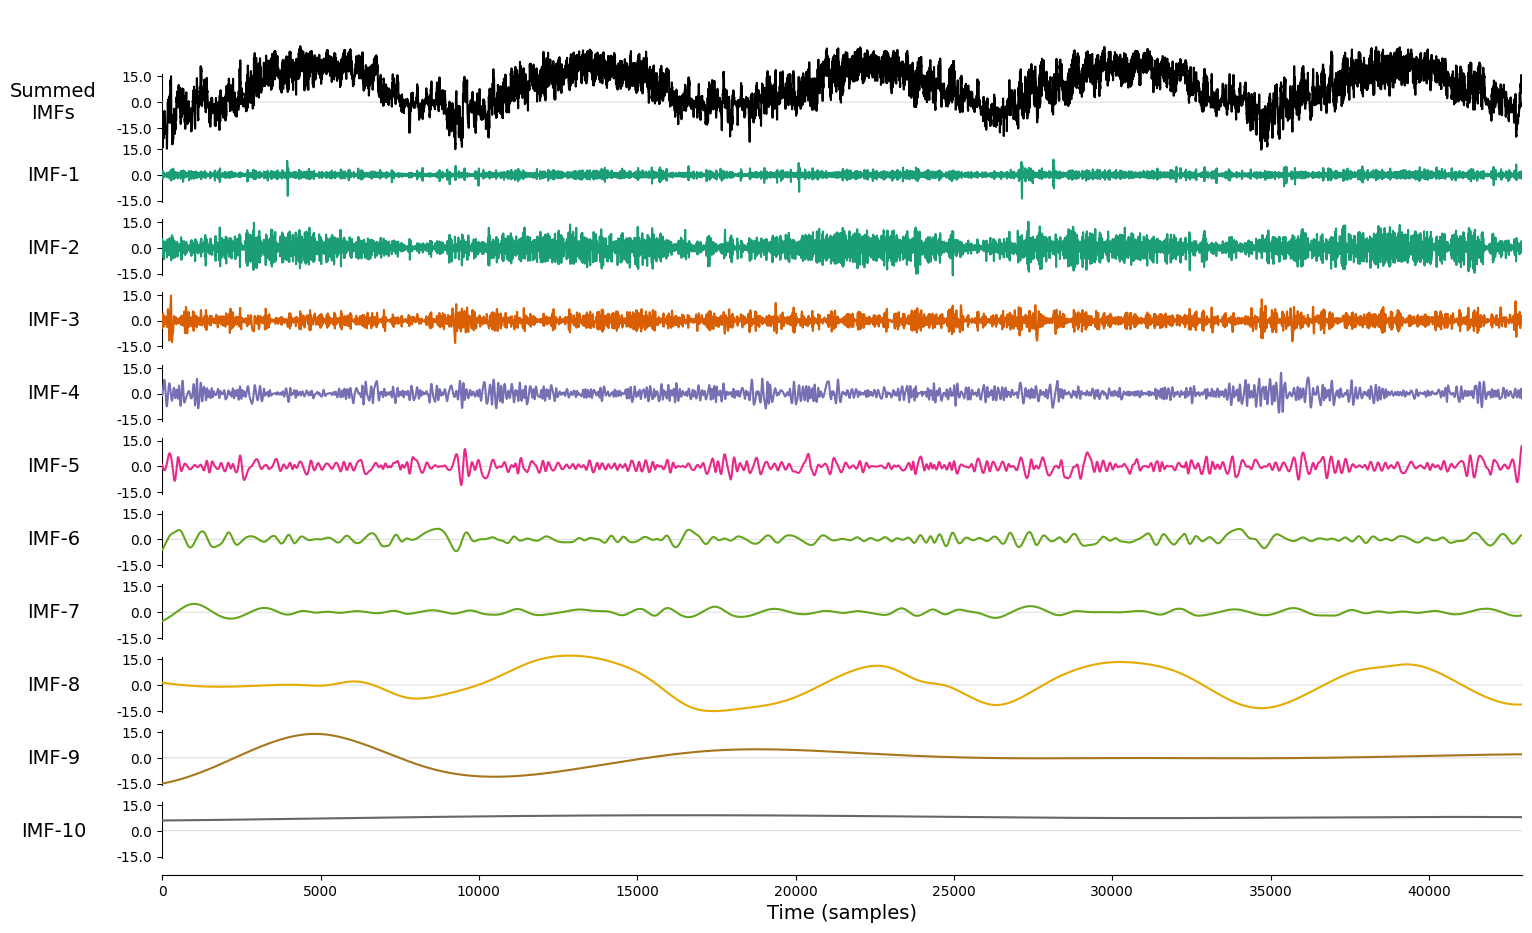

In [26]:
emd.plotting.plot_imfs(imf)

<Axes: title={'center': 'Hilbert-Huang Transform'}, xlabel='Time', ylabel='Frequency'>

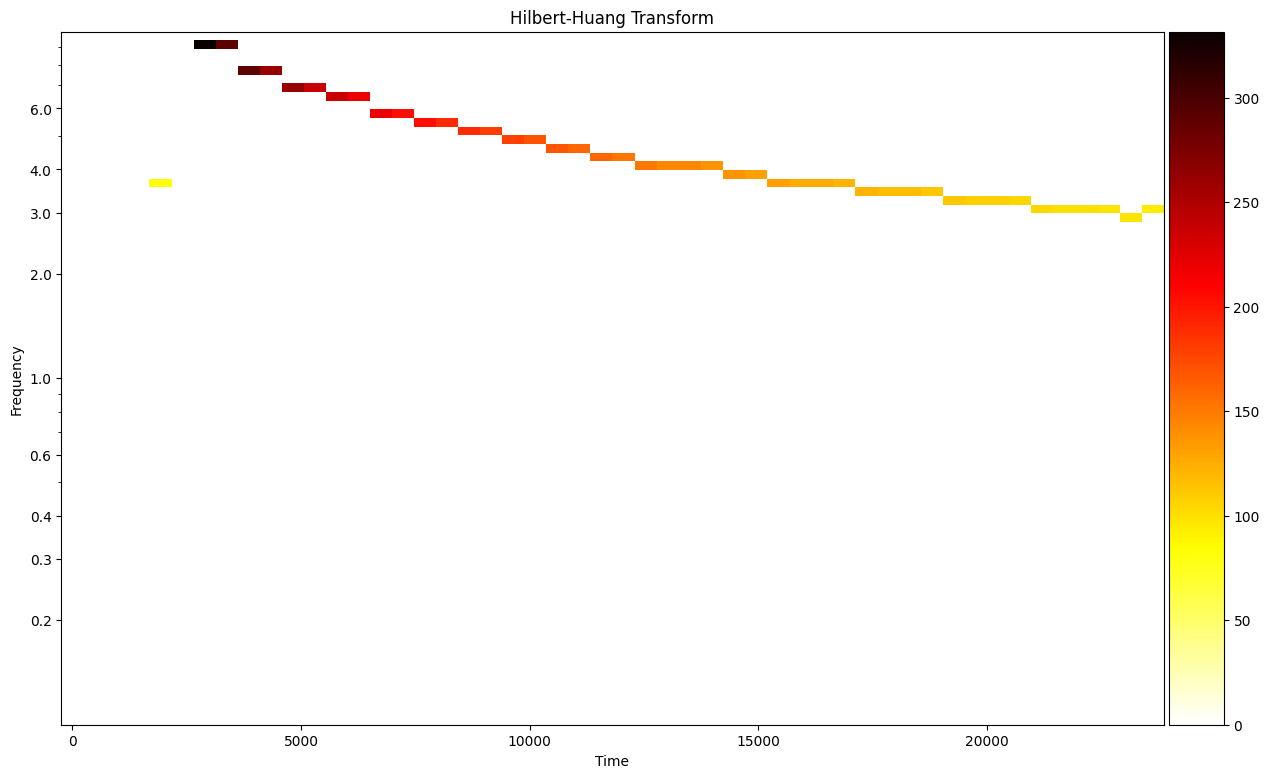

In [27]:
sample_rate = 23618
time_vect = np.linspace(0, sample_rate)
fig = plt.figure(figsize=(15, 9))
emd.plotting.plot_hilberthuang(hht, time_vect, f, fig=fig, log_y=True)

# ensemble sifting 

In [28]:
x = nysm_df["wspd_sonic"]
imf_opts = {"sd_thresh": 0.05}

/home/aevans/miniconda3/lib/python3.9/site-packages/emd/support.py:228: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  out_args[idx] = out_args[idx][:, np.newaxis]
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompat

<Axes: xlabel='Time (samples)'>

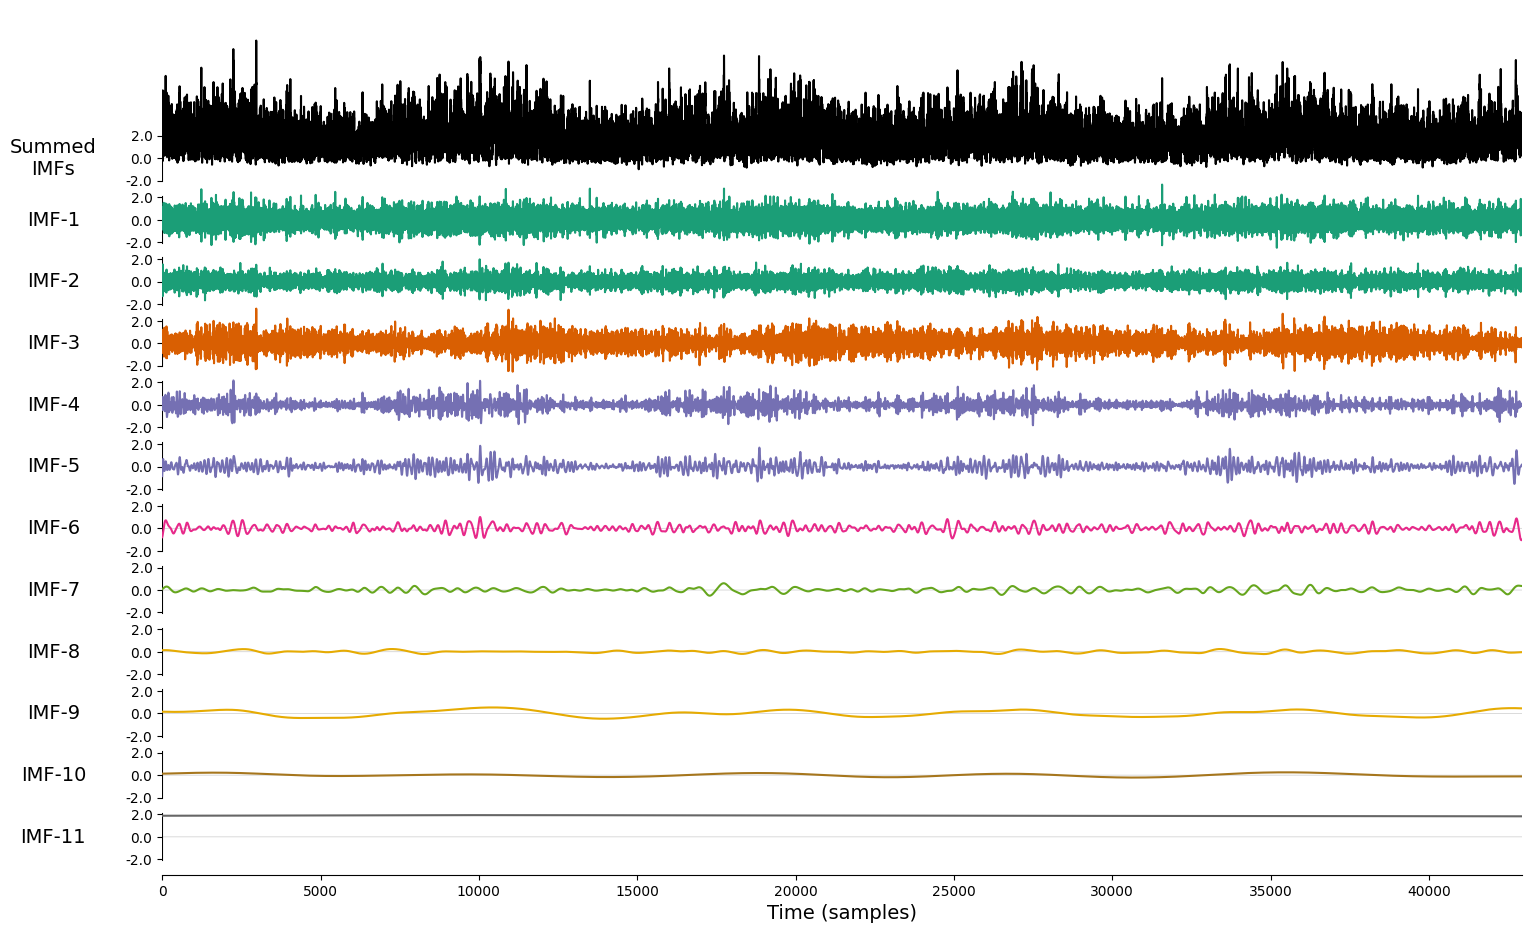

In [29]:
imf = emd.sift.ensemble_sift(
    x, nensembles=42, nprocesses=12, ensemble_noise=1, imf_opts=imf_opts
)
emd.plotting.plot_imfs(imf)

In [30]:
imf.shape

(42946, 11)

and now the Hilbert-Huang transform of this decomposition

In [31]:
sample_rate = 23618

time_vect = np.linspace(0, sample_rate - 0.5)

<Axes: title={'center': 'Hilbert-Huang Transform'}, xlabel='Time', ylabel='Frequency'>

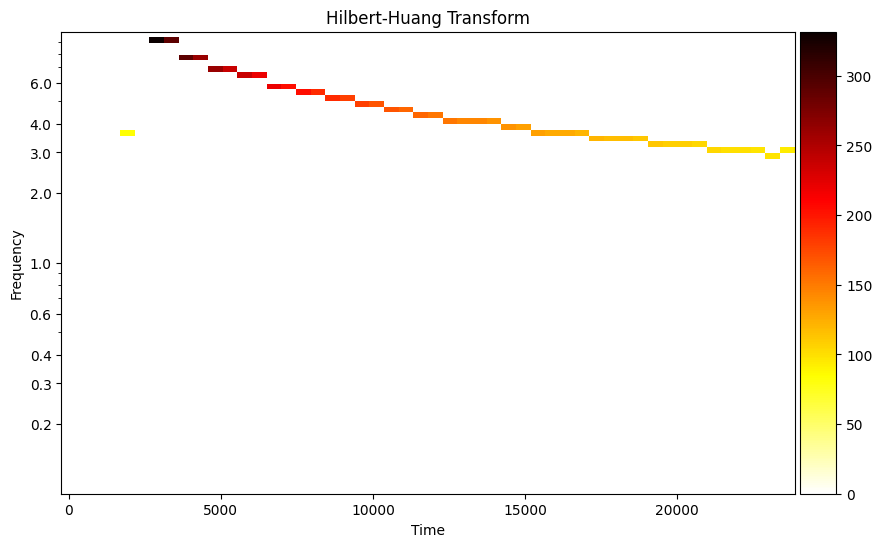

In [32]:
fig = plt.figure(figsize=(10, 6))
emd.plotting.plot_hilberthuang(hht, time_vect, f, fig=fig, log_y=True)